## Generate Data using SAMMY

This notebook works to couple the (recently) open source SAMMY code from ORNL to calculate a RRR cross section. The advantage of coupling to SAMMY is its ability to efficiently apply experimental corrections.

In [1]:
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import syndat
import os
import nuctools

In [2]:
%matplotlib widget

In [3]:
ac = 0.81271    # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider

Ta_pair = syndat.particle_pair(ac, M, m, I, i, l_max)

Ta_pair.map_quantum_numbers(True)


The following arrays describe all possible spin groups for a each parity.
    The data is given as a tuple where the first value is the integer 
    or half integer total quantum spin J and the second value is the 
    number of entrance channels for that spin group. 
    * See the dictionary "possible_Jpi" for a nested packing structure.

Spin group data for all parity
(Jpi, #Chs, l-waves)
(-5.0, 1, [1.0])
(-4.0, 2, [1.0, 1.0])
(-3.0, 2, [1.0, 1.0])
(-2.0, 1, [1.0])
(3.0, 1, [0.0])
(4.0, 1, [0.0])


In [4]:
E_min_max = [100, 300]
tof_min_max = syndat.exp_effects.e_to_t(np.array(E_min_max),35.185, True)+(3.326)*1e-6
bin_width = 6.4e-9
tof_grid = np.arange(min(tof_min_max), max(tof_min_max), bin_width)
energy_grid = syndat.exp_effects.t_to_e(tof_grid-(3.326)*1e-6,35.185,True)

In [5]:
# print(np.genfromtxt('/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JB_sol/ta_grp_s5.dat'  ,unpack=True,skip_header=12,max_rows=1))
# datafile_names = ['ch','counts','dcounts']
# pd.read_csv('/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JB_sol/ta_grp_s5.dat',delim_whitespace=True,names=datafile_names,
#                                          skiprows=14)

In [6]:

# spin_groups = [ (3.0,1,[0]), (4.0,1,[0]), (-4.0,2,[1.0, 1.0])]
spin_groups = [ (3.0,1,[0]), (4.0,1,[0])]

# an alternative option would be to give Ta_pair.J, as long as you give an average parameter dataframe with corresponding indices
# spin_groups = Ta_pair.J

average_parameters = pd.DataFrame({ 'dE'    :   {'3.0':20.0, '4.0':15.0, '-4.0':15.0},
                                    'Gg'    :   {'3.0':80.0, '4.0':55.0, '-4.0':55.0},
                                    'gn2'    :   {'3.0':50.0, '4.0':10.0, '-4.0':10.0}  })

In [7]:
resonance_ladder = Ta_pair.sample_resonance_ladder(energy_grid, spin_groups, average_parameters)
# resonance_ladder

### Calculate cross section using SAMMY

In [8]:
syndat.sammy_interface.calculate_xs(energy_grid, resonance_ladder, Ta_pair)
theo = syndat.sammy_interface.readlst('./SAMMY_runDIR/SAMMY.LST')

### Perform Syndat experiment

In [9]:
options = { 'Perform Experiment':True,
            'Add Noise': True,
            'Calculate Covariance': True,
            'Compression Points':[],
            'Grouping Factors':[10]}

exp = syndat.experiment(os.path.realpath('./SAMMY_runDIR/SAMMY.LST'), 
                        input_options=options)


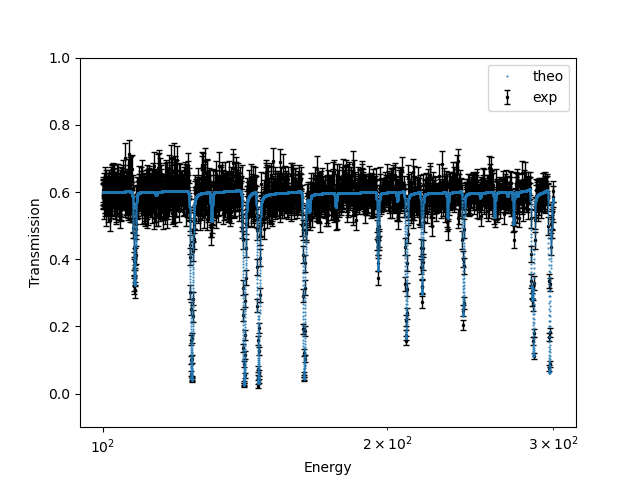

In [12]:
figure()
plot(theo.E, theo.theo_trans, '.', ms=1, label='theo')
errorbar(exp.trans.E, exp.trans.exp_trans, yerr=exp.trans.exp_trans_unc, zorder=0, 
                                        fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')

# plot(exp.trans.E, exp.trans.theo_trans, color='g', lw=1, label='Sol', zorder=2)

ylim([-.1, 1])
xscale('log')
xlabel('Energy'); ylabel('Transmission')
legend()